In [1]:
import os
import numpy as np
import rasterio as rio
from config import *
from data_acquisition import *
from richdem import TerrainAttribute, LoadGDAL
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [2]:
# --- Rutas
ndvi_path = "outputs/output_s2_2024-05-10_2024-05-12.tif"        # Sentinel-2 NDVI (alta resolución)
dem_path = "/home/tidop/Downloads/AP_07598_FBD_F0800_RT1/AP_07598_FBD_F0800_RT1.dem.tif"         # Elevación ALOS PALSAR 12.5m
lst_path = "outputs/output_s3_2024-05-04_2024-05-06.tif"         # LST Sentinel-3 rasterizado (baja resolución)
dem_clip_path = "outputs/output_dem_clip.tif"

# --- Clipping DEM
get_dem(os.path.join(GEOJSON_DIR, "networks.geojson"), dem_path, dem_clip_path, row=2)

In [3]:
# --- Leer DEM
dem_array = rio.open(dem_clip_path).read(1)

# --- Derivar atributos topográficos
dem_rd = LoadGDAL(dem_clip_path)

slope = TerrainAttribute(dem_rd, attrib='slope_degrees')
aspect = TerrainAttribute(dem_rd, attrib='aspect')
curvature = TerrainAttribute(dem_rd, attrib='curvature')  # Puede actuar como un proxy de TPI


A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.274919======================= ] (99% - 0.0s - 1 threads)===============       ] (86% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.156162======================= ] (99% - 0.0s - 1 threads)                       ] (9% - 0.2s - 1 threads)

A Curvature attribute calculation
C Zevenbergen, L.W., Thorne, C.R., 1987. Quantitative analysis of land surface topography. Earth surface processes and landforms 12, 47–56.

t Wall-time = 0.0325128====================== ] (99% - 0.0s - 1 threads)


In [24]:
dem_array.shape # resolucion = 12.5
dem_array.shape[0]/2
dem_array.shape[0] // 2 # resolucion = 12.5

1005

In [30]:
# --- Leer NDVI y LST
ndvi_10m = rio.open(ndvi_path).read(1)
lst = rio.open(lst_path).read(1)

# --- Reducción a 100m
target_shape = (dem_array.shape[0] // 2, dem_array.shape[1] // 2)

ndvi_100m = resize(ndvi_10m, target_shape, order=1)
dem_100m = resize(dem_array, target_shape, order=1)
slope_100m = resize(slope, target_shape, order=1)
aspect_100m = resize(aspect, target_shape, order=1)
curvature_100m = resize(curvature, target_shape, order=1)
lst_upsampled_100m = resize(lst, target_shape, order=1)

In [31]:
target_shape

(1005, 934)

In [32]:
# --- Stack de variables
X = np.stack([
    ndvi_100m.flatten(),
    dem_100m.flatten(),
    slope_100m.flatten(),
    aspect_100m.flatten(),
    curvature_100m.flatten(),
], axis=1)
y = lst_upsampled_100m.flatten()

# --- Máscara de limpieza
mask = ~np.isnan(y) & np.isfinite(y) & np.isfinite(X).all(axis=1)
X_clean = X[mask]
y_clean = y[mask]

# --- Submuestreo
max_samples = 1_000_000
if len(X_clean) > max_samples:
    X_clean, y_clean = shuffle(X_clean, y_clean, random_state=42)
    X_clean = X_clean[:max_samples]
    y_clean = y_clean[:max_samples]

In [33]:
# --- Entrenamiento
model = RandomForestRegressor(n_estimators=50, max_depth=25, n_jobs=-1)
model.fit(X_clean, y_clean)

# --- Predicción
y_pred = model.predict(X_clean)

# --- Reconstrucción del raster
lst_100m = np.full(target_shape, np.nan)
lst_100m.flat[mask] = y_pred

# --- Métricas
print("R²:", r2_score(y_clean, y_pred))
print("RMSE:", mean_squared_error(y_clean, y_pred, squared=False))

R²: 0.657330188739202
RMSE: 3.0739578613113285


/home/tidop/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


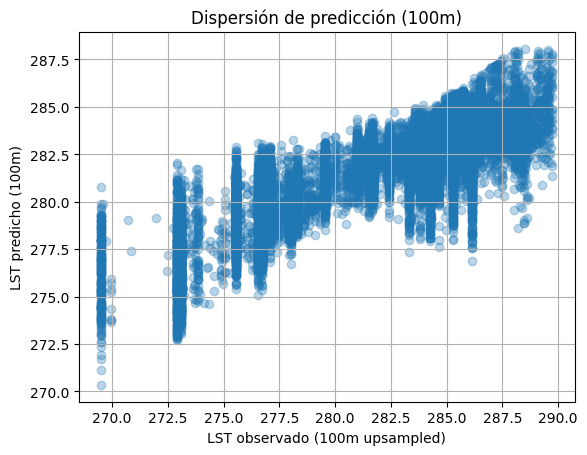

In [34]:
# --- Visualización
plt.scatter(y_clean[:30000], y_pred[:30000], alpha=0.3)
plt.xlabel("LST observado (100m upsampled)")
plt.ylabel("LST predicho (100m)")
plt.title("Dispersión de predicción (100m)")
plt.grid()
plt.show()